<a href="https://colab.research.google.com/github/DimpleB0501/eva8/blob/main/Session_8_Assignment_QnA/Session_8_Assignment_QnA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Import dependencies

In [1]:
!pip install --upgrade albumentations
!pip install torchscan
!pip3 install grad-cam

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 12.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.4.6-py3-none-any.whl size=38261 sha256=27615e559feaae292e51d872cbce19627cf920026283cab4a8f2e4381c9d6c99
  Stored in directory: /root/.cache/pip/wheels/53/02/43/1f75726b5c28459596067ad91e36951463c01273eef661f09f
Successfully built grad-cam


### GPU check

In [2]:
import torch
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

CUDA Available? True


### Importing files from github

In [3]:
!ls
!rm -rf .git
!rm -rf eva_base_code
!ls

eva_base_code  sample_data
sample_data


In [4]:
!git clone https://github.com/DimpleB0501/eva_base_code.git

Cloning into 'eva_base_code'...
remote: Enumerating objects: 107, done.
remote: Counting objects: 100% (107/107), done.
remote: Compressing objects: 100% (99/99), done.
remote: Total 107 (delta 48), reused 0 (delta 0), pack-reused 0
Receiving objects: 100% (107/107), 28.48 KiB | 7.12 MiB/s, done.
Resolving deltas: 100% (48/48), done.


In [5]:
cd eva_base_code

/content/eva_base_code


In [6]:
from eva_base_code.models import custom_resnet
import main
import utils

### Dataset preparation

In [7]:
import torchvision

In [8]:
mean, std = utils.data_param()
trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=utils.train_transform_func_8(mean, std)) # RandomCrop 32, 32 (after padding of 4) >> FlipLR >> Followed by CutOut(8, 8)
testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=utils.test_transform_func(mean, std))

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data


/usr/local/lib/python3.8/dist-packages/albumentations/augmentations/dropout/cutout.py:49: FutureWarning: Cutout has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified


In [9]:
batch_size = 512
trainloader, testloader = main.split_data_set(trainset, testset, cuda, batch_size)

/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


### Show training images

In [10]:
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

 ship  bird   cat   dog  bird


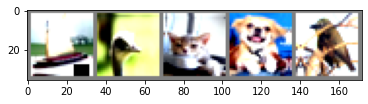

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# show images
imshow(torchvision.utils.make_grid(images[:5]))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(5)))

### Custom resnet model

In [12]:
from torchscan import summary
device = torch.device("cuda" if cuda else "cpu")
model = custom_resnet.Net().to(device)
summary(model, (3, 32, 32), receptive_field=True, max_depth=1)

_______________________________________________________________________________
Layer           Type          Output Shape         Param #      Receptive field
net             Net           (-1, 10)             0            1              
├─prep_layer    Sequential    (-1, 64, 32, 32)     1,985        3              
├─layer1_x      Sequential    (-1, 128, 16, 16)    74,241       6              
├─layer1_res    Sequential    (-1, 128, 16, 16)    295,938      14             
├─layer2        Sequential    (-1, 256, 8, 8)      295,937      20             
├─layer3_x      Sequential    (-1, 512, 4, 4)      1,181,697    32             
├─layer3_res    Sequential    (-1, 512, 4, 4)      4,722,690    64             
├─pool          MaxPool2d     (-1, 512, 1, 1)      0            88             
├─fc            Linear        (-1, 10)             5,120        88             
Trainable params: 6,573,120
Non-trainable params: 0
Total params: 6,573,120
--------------------------------------------

# Test and train loops

In [13]:
num_epochs = 24 # change to 20
#learning_rate = 0.01 #0.025 # change to 0.01

In [14]:
# LRMAX = FIND max learning rate
# max LR finder https://github.com/davidtvs/pytorch-lr-finder
!pip install torch-lr-finder

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.8/dist-packages/torch/utils/data/dataloader.py:554: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


  0%|          | 0/100 [00:00<?, ?it/s]

Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 8.11E-04


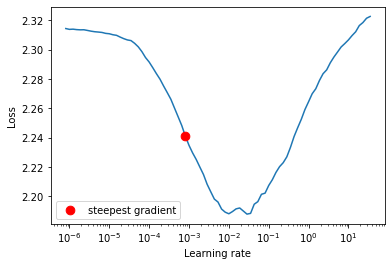

In [15]:
from torch_lr_finder import LRFinder
import torch.nn as nn
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainloader, end_lr=100, num_iter=100)
_, lr_suggested = lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [16]:
print ("suggested learning rate: ", lr_suggested)
max_learning_rate = lr_suggested #0.025 # change to 0.01

suggested learning rate:  0.0008111308307896874


### Training

In [17]:
# Implemented scheduler in main.py
# Max at Epoch = 5
#pct_start = 0.2 #(~5/24)
#scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = learning_rate, epochs = epochs, steps_per_epoch = len(trainloader), pct_start = pct_start) 

In [18]:
# trigger training
train_acc, train_losses, test_acc, test_losses, l_rate = main.start_training_process(model, device, trainloader, testloader, optimizer = "Adam", learning_rate = max_learning_rate, epochs = num_epochs)

EPOCH: 1


Loss=2.0163145065307617 Batch_id=97 Accuracy=34.03% learning_rate=0.00011323: 100%|██████████| 98/98 [00:29<00:00,  3.31it/s]



Test set: Average loss: 0.0040, Accuracy: 4571/10000 (45.71%)

EPOCH: 2


Loss=1.941335916519165 Batch_id=97 Accuracy=49.59% learning_rate=0.00032207: 100%|██████████| 98/98 [00:29<00:00,  3.29it/s]



Test set: Average loss: 0.0038, Accuracy: 5538/10000 (55.38%)

EPOCH: 3


Loss=1.8401654958724976 Batch_id=97 Accuracy=61.13% learning_rate=0.00057229: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 0.0038, Accuracy: 5363/10000 (53.63%)

EPOCH: 4


Loss=1.7268133163452148 Batch_id=97 Accuracy=67.66% learning_rate=0.00076005: 100%|██████████| 98/98 [00:27<00:00,  3.59it/s]



Test set: Average loss: 0.0035, Accuracy: 7026/10000 (70.26%)

EPOCH: 5


Loss=1.6433988809585571 Batch_id=97 Accuracy=75.53% learning_rate=0.00081089: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 0.0034, Accuracy: 7717/10000 (77.17%)

EPOCH: 6


Loss=1.6657048463821411 Batch_id=97 Accuracy=80.23% learning_rate=0.00080321: 100%|██████████| 98/98 [00:27<00:00,  3.54it/s]



Test set: Average loss: 0.0034, Accuracy: 7861/10000 (78.61%)

EPOCH: 7


Loss=1.6452889442443848 Batch_id=97 Accuracy=82.81% learning_rate=0.00078490: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]



Test set: Average loss: 0.0034, Accuracy: 7598/10000 (75.98%)

EPOCH: 8


Loss=1.6384538412094116 Batch_id=97 Accuracy=84.59% learning_rate=0.00075646: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.0034, Accuracy: 7417/10000 (74.17%)

EPOCH: 9


Loss=1.5949301719665527 Batch_id=97 Accuracy=86.57% learning_rate=0.00071864: 100%|██████████| 98/98 [00:26<00:00,  3.64it/s]



Test set: Average loss: 0.0033, Accuracy: 8169/10000 (81.69%)

EPOCH: 10


Loss=1.5931618213653564 Batch_id=97 Accuracy=87.95% learning_rate=0.00067246: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 0.0033, Accuracy: 8226/10000 (82.26%)

EPOCH: 11


Loss=1.556816816329956 Batch_id=97 Accuracy=89.30% learning_rate=0.00061916: 100%|██████████| 98/98 [00:28<00:00,  3.49it/s]



Test set: Average loss: 0.0032, Accuracy: 8620/10000 (86.20%)

EPOCH: 12


Loss=1.561124324798584 Batch_id=97 Accuracy=90.43% learning_rate=0.00056014: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]



Test set: Average loss: 0.0032, Accuracy: 8687/10000 (86.87%)

EPOCH: 13


Loss=1.5537654161453247 Batch_id=97 Accuracy=91.47% learning_rate=0.00049700: 100%|██████████| 98/98 [00:27<00:00,  3.53it/s]



Test set: Average loss: 0.0032, Accuracy: 8719/10000 (87.19%)

EPOCH: 14


Loss=1.5412448644638062 Batch_id=97 Accuracy=92.45% learning_rate=0.00043142: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0032, Accuracy: 8602/10000 (86.02%)

EPOCH: 15


Loss=1.539030909538269 Batch_id=97 Accuracy=93.06% learning_rate=0.00036514: 100%|██████████| 98/98 [00:27<00:00,  3.55it/s]



Test set: Average loss: 0.0032, Accuracy: 8824/10000 (88.24%)

EPOCH: 16


Loss=1.525270700454712 Batch_id=97 Accuracy=94.08% learning_rate=0.00029995: 100%|██████████| 98/98 [00:29<00:00,  3.37it/s]



Test set: Average loss: 0.0031, Accuracy: 8929/10000 (89.29%)

EPOCH: 17


Loss=1.520719289779663 Batch_id=97 Accuracy=94.75% learning_rate=0.00023757: 100%|██████████| 98/98 [00:28<00:00,  3.50it/s]



Test set: Average loss: 0.0031, Accuracy: 8974/10000 (89.74%)

EPOCH: 18


Loss=1.5132074356079102 Batch_id=97 Accuracy=95.49% learning_rate=0.00017969: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]



Test set: Average loss: 0.0031, Accuracy: 8981/10000 (89.81%)

EPOCH: 19


Loss=1.5026448965072632 Batch_id=97 Accuracy=95.86% learning_rate=0.00012783: 100%|██████████| 98/98 [00:27<00:00,  3.57it/s]



Test set: Average loss: 0.0031, Accuracy: 8980/10000 (89.80%)

EPOCH: 20


Loss=1.4920109510421753 Batch_id=97 Accuracy=96.23% learning_rate=0.00008340: 100%|██████████| 98/98 [00:27<00:00,  3.61it/s]



Test set: Average loss: 0.0031, Accuracy: 9038/10000 (90.38%)

EPOCH: 21


Loss=1.52261221408844 Batch_id=97 Accuracy=96.51% learning_rate=0.00004757: 100%|██████████| 98/98 [00:27<00:00,  3.51it/s]



Test set: Average loss: 0.0031, Accuracy: 9049/10000 (90.49%)

EPOCH: 22


Loss=1.5048097372055054 Batch_id=97 Accuracy=96.76% learning_rate=0.00002131: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]



Test set: Average loss: 0.0031, Accuracy: 9068/10000 (90.68%)

EPOCH: 23


Loss=1.4923325777053833 Batch_id=97 Accuracy=96.80% learning_rate=0.00000531: 100%|██████████| 98/98 [00:29<00:00,  3.32it/s]



Test set: Average loss: 0.0031, Accuracy: 9087/10000 (90.87%)

EPOCH: 24


Loss=1.4979608058929443 Batch_id=97 Accuracy=96.86% learning_rate=0.00000000: 100%|██████████| 98/98 [00:27<00:00,  3.58it/s]



Test set: Average loss: 0.0031, Accuracy: 9090/10000 (90.90%)



### Plot train and test loss and accuracies

Text(0.5, 1.0, 'Test Accuracy')

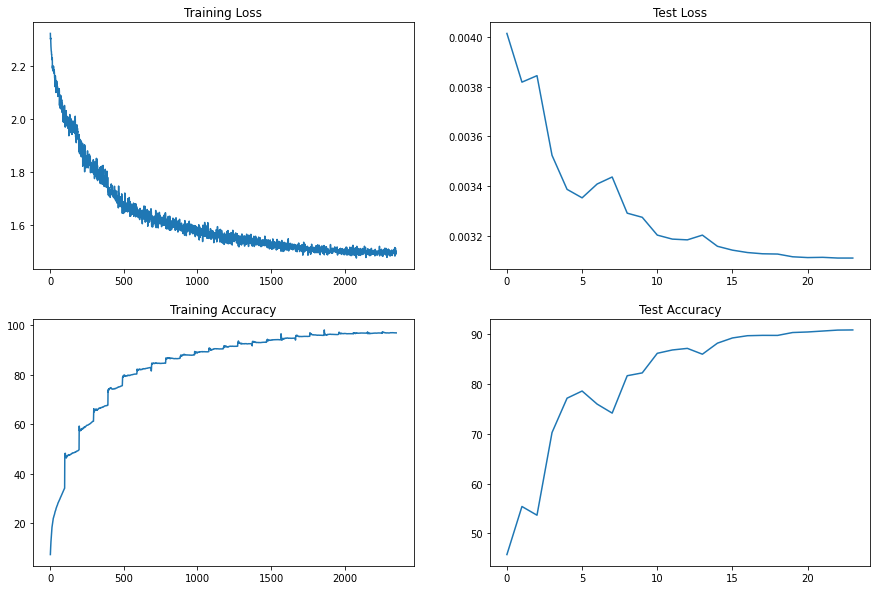

In [19]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

### Learning rate plot

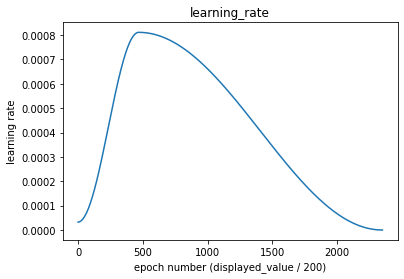

In [20]:
plt.plot(l_rate)
plt.title("learning_rate")
plt.xlabel("epoch number (displayed_value / 200)")
plt.ylabel("learning rate")
plt.show()